# 자율주행 센서의 안테나 성능 예측 AI 경진대회

- Name    :  Jeonghyeon Kim (Henney Kim)
- E-mail  :  zmsdkdle@khu.ac.kr, kjh3765@hotmail.com

In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

In [129]:
train = pd.read_csv('./train.csv')

## EDA & Data Preprocessing

### 데이터 분포

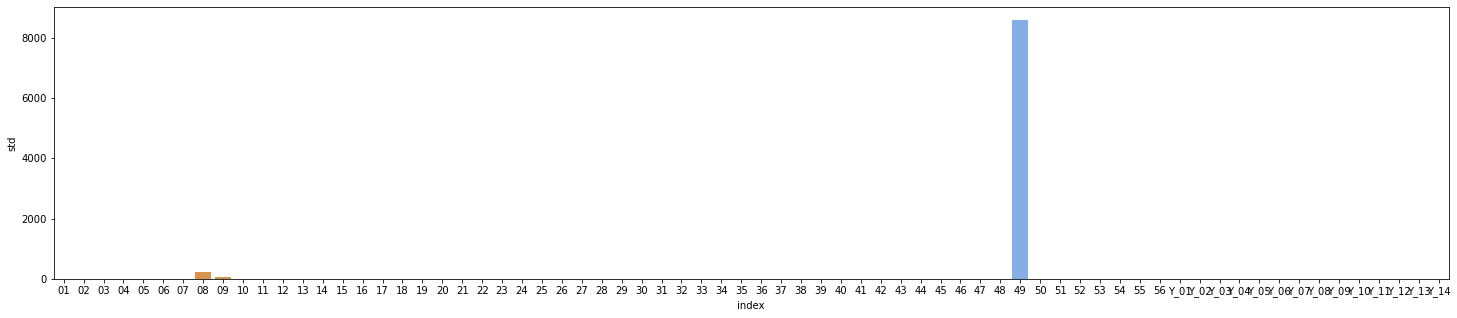

In [25]:
# 특성의 편차를 시각화
plt.figure(figsize=(25, 5))
data_std = pd.DataFrame(train.describe().iloc[2, :])
data_std = data_std.reset_index()
data_std.replace('X_', '', regex=True, inplace=True)
sns.barplot(x = 'index', y='std', data=data_std)
plt.show()

# X_49(Cal 투입 전 대기 시간)의 경우 편차가 매우 큼

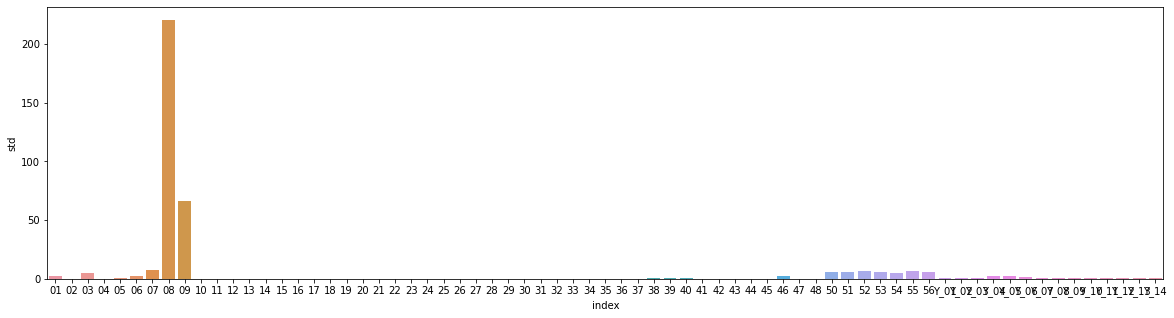

In [26]:
# 49번째 특성을 제외하고 시각화
plt.figure(figsize=(20, 5))
sns.barplot(x = 'index', y='std', data=data_std.drop(data_std.index[48]))
plt.show()

# 값이 매우큰 X_49를 제외했을 때, 그 다음으로 X_8과 X_9가 편차가 큰 것을 확인할 수 있음

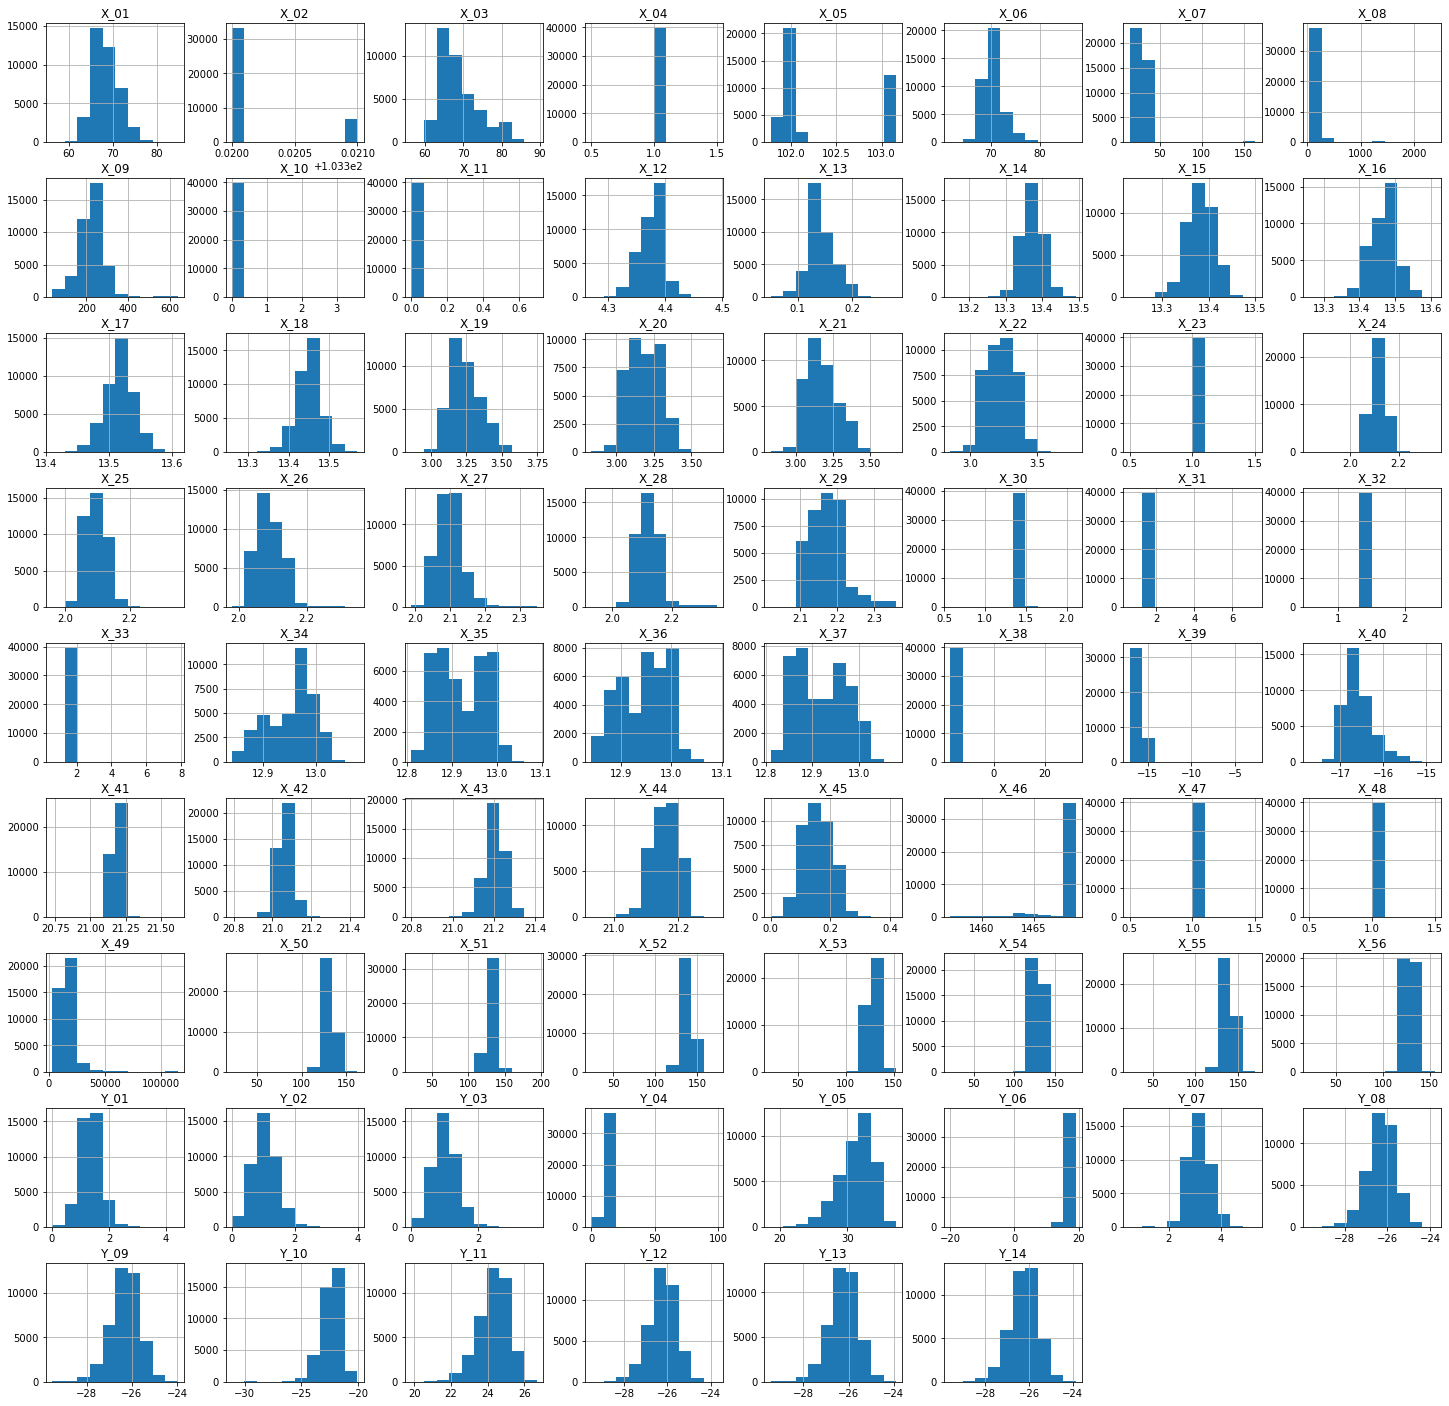

In [31]:
train.iloc[:, 1:].hist(figsize=(25, 25))
plt.show()

In [122]:
print(train_x.loc[:, ['X_07', 'X_08', 'X_09', 'X_03', 'X_10', 'X_11']].head(), '\n')

print('X_10 특성 0의 개수:', sum(train_x.X_10 == 0))
print('X_11 특성 0의 개수:', sum(train_x.X_11 == 0))

# 방열 재료 2, 3의 경우 면적은 있지만 무게가 0인 데이터가 많음 --> X_10, X_11 제거

    X_07    X_08    X_09   X_03  X_10  X_11
0  29.45   62.38  245.71  67.47   0.0   0.0
1  28.73   61.23  233.61  65.17   0.0   0.0
2  28.81  105.77  272.20  64.07   0.0   0.0
3  28.92  115.21  255.36  67.57   0.0   0.0
4  29.68  103.38  241.46  63.57   0.0   0.0 

X_10 특성 0의 개수: 39575
X_11 특성 0의 개수: 39580


In [133]:
print('X_04 값: ', train_x.X_04.unique())
print('X_23 값: ', train_x.X_23.unique())
print('X_47 값: ', train_x.X_47.unique())
print('X_48 값: ', train_x.X_48.unique())
# 1~4차 검사 통과 여부는 모두 1 --> 제거

X_04 값:  [1]
X_23 값:  [1]
X_47 값:  [1]
X_48 값:  [1]


In [92]:
# X_04 X_23, X_47, X_48 제거
train.drop(['X_04', 'X_10', 'X_11', 'X_23', 'X_47', 'X_48'], axis=1, inplace=True)

In [ ]:
# Feature ~ Y correlation
df_corr = train.corr().filter(regex='Y')

plt.figure(figsize=(15, 15))
sns.heatmap(df_corr, cmap='RdBu_r', vmax=1, vmin=-1, annot=True, fmt='.1f')
plt.show()

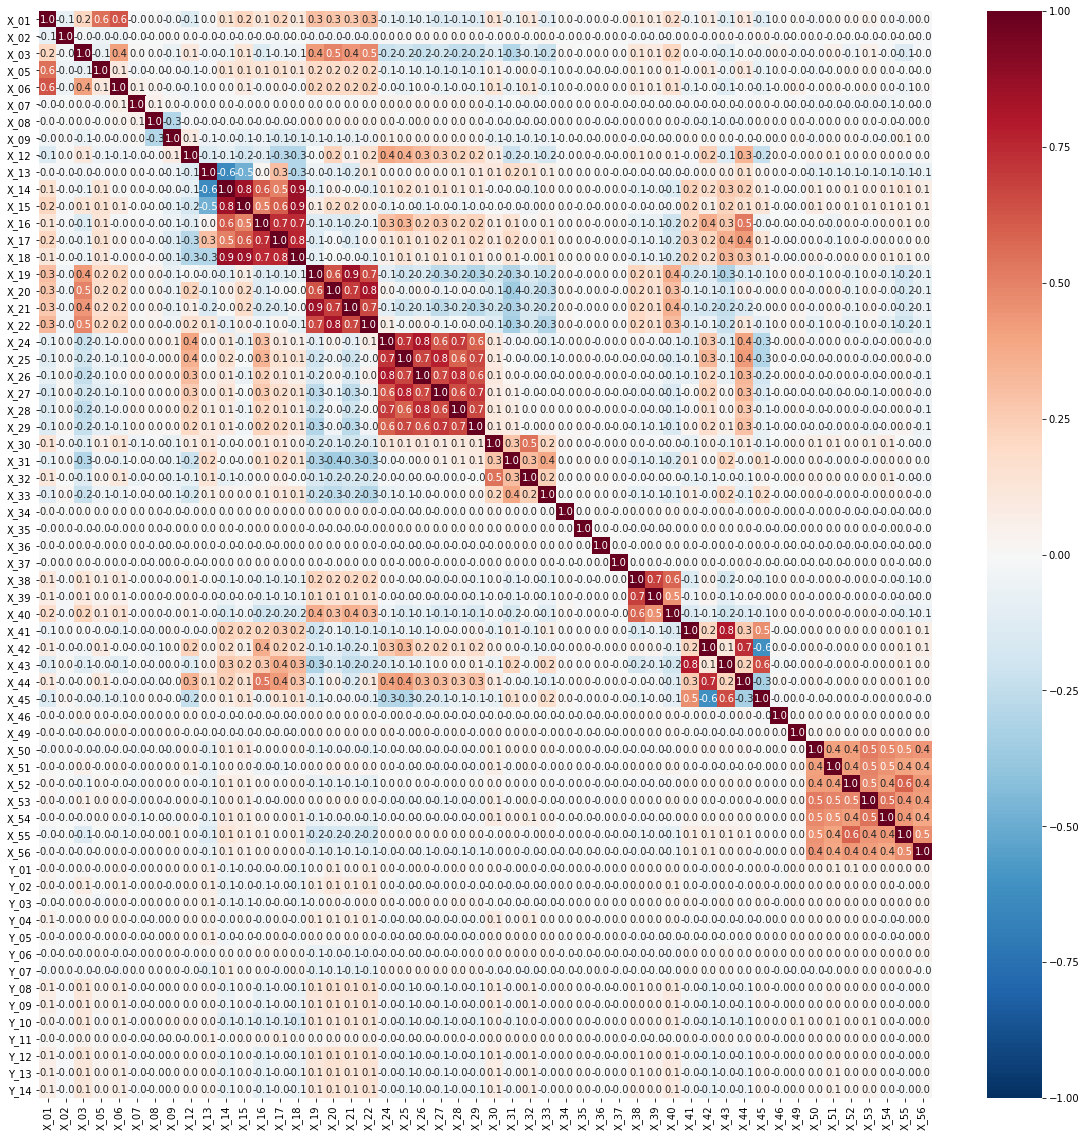

In [35]:
# Features correlation
df_corr = train.corr().filter(regex='X')

plt.figure(figsize=(20, 20))
sns.heatmap(df_corr, cmap='RdBu_r', vmax=1, vmin=-1, annot=True, fmt='.1f')
plt.show()

## 연관있어 보이는 변수
# 각 비슷한 단계에 따라서 뚜렷한 상관관계를 지님

### Normalization

In [130]:
train_x = train.filter(regex='X')
train_y = train.filter(regex='Y')
x_colname = train_x.columns

scaler = MinMaxScaler()
scaler.fit(train_x)
train_x = scaler.transform(train_x)
train_x = pd.DataFrame(train_x, columns=x_colname)
train_x

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,0.500000,0.0,0.336391,0.0,0.085137,0.520025,0.102258,0.010183,0.346935,0.0,...,0.0,0.0,0.057221,0.818378,0.657283,0.829713,0.861965,0.678313,0.772826,0.774036
1,0.464276,1.0,0.266055,0.0,0.122655,0.440003,0.097449,0.009694,0.326766,0.0,...,0.0,0.0,0.063671,0.794895,0.660879,0.843594,0.780464,0.693197,0.817679,0.772908
2,0.571414,0.0,0.232416,0.0,0.994949,0.440003,0.097983,0.028655,0.391092,0.0,...,0.0,0.0,0.068392,0.788280,0.632348,0.822906,0.820963,0.687465,0.797791,0.753194
3,0.535689,0.0,0.339450,0.0,0.142136,0.600008,0.098718,0.032674,0.363021,0.0,...,0.0,0.0,0.104882,0.797750,0.645002,0.775716,0.846305,0.711607,0.846910,0.847593
4,0.464276,0.0,0.217125,0.0,0.149351,0.360020,0.103794,0.027638,0.339851,0.0,...,0.0,0.0,0.069314,0.858752,0.664588,0.743346,0.865374,0.678588,0.790558,0.760922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39602,0.357138,0.0,0.177370,0.0,0.992785,0.200016,0.107267,0.016760,0.434182,0.0,...,0.0,0.0,0.515087,0.768116,0.630910,0.734221,0.792995,0.653432,0.752841,0.803928
39603,0.357138,1.0,0.192661,0.0,0.178211,0.200016,0.100655,0.027156,0.388542,0.0,...,0.0,0.0,0.516280,0.751557,0.569218,0.795323,0.771575,0.661280,0.816103,0.757476
39604,0.428551,0.0,0.250765,0.0,0.988456,0.279998,0.105664,0.027310,0.267523,0.0,...,0.0,0.0,0.049194,0.786122,0.666170,0.740457,0.822309,0.712888,0.798427,0.730249
39605,0.357138,0.0,0.220183,0.0,0.181097,0.240027,0.107935,0.031563,0.396626,0.0,...,0.0,0.0,0.529397,0.755504,0.576965,0.786145,0.830138,0.677749,0.772026,0.770283


### Create Derived Variable(clustering)

In [ ]:
# kmeans으로 feature clustering

# cluster 1 (X_14~18)
# 적절 군집수 확인
n_num = range(2, 10)
inertias = []
for n in n_num:
    kmeans = KMeans(n_clusters=n).fit(train_x.loc[:, ["X_30", "X_31", "X_32", "X_33"]])
    inertias.append(kmeans.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(n_num, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(n_num)
plt.show()

In [56]:
kmeans = KMeans(n_clusters=3).fit(train_x.loc[:, ["X_13", "X_14", "X_15", "X_16", "X_17", "X_18",]])
clusters = kmeans.predict(train_x.loc[:, ["X_13", "X_14", "X_15", "X_16", "X_17", "X_18",]])
train_x['X_57'] = clusters
train_x['X_57'] = train_x['X_57'].astype('str')

ohe = OneHotEncoder(sparse=False)
dummies = ohe.fit_transform(train_x[['X_57']])

train_x.drop(['X_57'], axis=1, inplace=True)

train_x['X_57'] = dummies[:, 0]
train_x['X_58'] = dummies[:, 1]
train_x['X_59'] = dummies[:, 2]

## Modeling

In [168]:
def MyModel(x_train, y_train, x_val, y_val, i=0):
    input = Input(shape=(x_train.shape[1], ))
    x = BatchNormalization()(input)
    x = Dense(256, activation='relu',)(x)
    x = BatchNormalization()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dense(y_train.shape[1])(x)

    model = Model(inputs=input, outputs=x)
    
    model.compile(loss = 'mae', optimizer='adam')

    es = EarlyStopping(monitor='val_loss', patience=20)
    cp = ModelCheckpoint(filepath=f'./model_{str(i)}.h5',
                         monitor='val_loss',
                         save_best_only=True)
    
    model.fit(x_train, y_train,
              epochs=50, validation_data=(x_val, y_val),
              callbacks=[es, cp], batch_size=128)
    
    return model

SyntaxError: invalid syntax (<ipython-input-168-81847f9d3a91>, line 2)

In [134]:
from sklearn.model_selection import KFold
kf = KFold(5, shuffle=True)
i=0

for train_index, val_index in kf.split(train_x):
    i += 1
    fold_train_x, fold_val_x = train_x.loc[train_index], train_x.loc[val_index]
    fold_train_y, fold_val_y = train_y.loc[train_index], train_y.loc[val_index]
    model = MyModel(fold_train_x, fold_train_y, fold_val_x, fold_val_y, i)
    print(f'{str(i)} model done.')

Epoch 1/50
248/248 [==============================] - 5s 17ms/step - loss: 16.1975 - val_loss: 13.5123
Epoch 2/50
248/248 [==============================] - 4s 15ms/step - loss: 9.1592 - val_loss: 3.8521
Epoch 3/50
248/248 [==============================] - 4s 15ms/step - loss: 1.4635 - val_loss: 0.8263
Epoch 4/50
248/248 [==============================] - 4s 16ms/step - loss: 0.7106 - val_loss: 0.7276
Epoch 5/50
248/248 [==============================] - 4s 15ms/step - loss: 0.7024 - val_loss: 0.7058
Epoch 6/50
248/248 [==============================] - 4s 16ms/step - loss: 0.6995 - val_loss: 0.6987
Epoch 7/50
248/248 [==============================] - 4s 15ms/step - loss: 0.6964 - val_loss: 0.7004
Epoch 8/50
248/248 [==============================] - 4s 15ms/step - loss: 0.6945 - val_loss: 0.6956
Epoch 9/50
248/248 [==============================] - 4s 15ms/step - loss: 0.6923 - val_loss: 0.6987
Epoch 10/50
248/248 [==============================] - 4s 15ms/step - loss: 0.6891 - val_

## Inference

In [139]:
# test 데이터 로드 및 특성 제거
test_x = pd.read_csv('./test.csv').drop(columns=['ID'])
#test_x.drop(['X_04', 'X_10', 'X_11', 'X_23', 'X_47', 'X_48'], axis=1, inplace=True)
test_x.head()

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,68.504,103.321,76.67,1,101.867,73.963,30.51,63.57,239.80,0.0,...,1,1,17227.63,138.130429,129.460682,141.506570,133.427229,129.711498,133.138096,121.859684
1,67.485,103.320,69.37,1,101.992,67.845,28.03,116.99,189.23,0.0,...,1,1,17134.53,136.148839,128.266277,145.911745,131.196417,132.411480,133.629025,124.178623
2,69.524,103.320,68.97,1,101.884,77.022,29.65,205.68,214.93,0.0,...,1,1,14860.83,120.447446,119.988804,132.099908,120.450155,130.051708,128.252972,114.475628
3,69.524,103.320,65.87,1,101.866,73.963,28.15,103.38,180.80,0.0,...,1,1,15252.53,133.994695,125.069180,147.507669,123.142653,125.963665,139.666592,126.589253
4,73.603,103.321,66.67,1,101.891,74.983,29.92,71.20,231.93,0.0,...,1,1,10752.23,137.918202,135.116192,138.600473,127.173033,137.252712,134.411335,124.020016


In [140]:
# 정규화
test_x = scaler.transform(test_x)
test_x = pd.DataFrame(test_x, columns=x_colname)
test_x

,X_01,X_02,X_03,X_04,X_05,X_06,X_07,X_08,X_09,X_10,...,X_47,X_48,X_49,X_50,X_51,X_52,X_53,X_54,X_55,X_56
0,0.428551,1.0,0.617737,0.0,0.067100,0.480014,0.109337,0.010690,0.337084,0.0,...,0.0,0.0,0.124848,0.826096,0.623109,0.787599,0.855204,0.705025,0.748479,0.750366
1,0.392862,0.0,0.394495,0.0,0.157287,0.240027,0.092773,0.033432,0.252788,0.0,...,0.0,0.0,0.124011,0.812024,0.616190,0.816901,0.838185,0.722591,0.751814,0.767689
2,0.464276,0.0,0.382263,0.0,0.079365,0.600008,0.103593,0.071188,0.295628,0.0,...,0.0,0.0,0.103568,0.700524,0.568233,0.725029,0.756200,0.707239,0.715286,0.695207
3,0.464276,0.0,0.287462,0.0,0.066378,0.480014,0.093575,0.027638,0.238736,0.0,...,0.0,0.0,0.107090,0.796727,0.597667,0.827516,0.776741,0.680643,0.792837,0.785696
4,0.607138,1.0,0.311927,0.0,0.084416,0.520025,0.105397,0.013938,0.323965,0.0,...,0.0,0.0,0.066627,0.824589,0.655875,0.768269,0.807490,0.754086,0.757130,0.766504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39603,0.428551,0.0,0.229358,0.0,0.997835,0.279998,0.102525,0.033159,0.411028,0.0,...,0.0,0.0,0.528509,0.752320,0.605923,0.771724,0.792980,0.695742,0.796305,0.798422
39604,0.428551,0.0,0.149847,0.0,0.983405,0.279998,0.121226,0.033129,0.391442,0.0,...,0.0,0.0,0.525997,0.752505,0.591836,0.765862,0.751846,0.689484,0.776839,0.822908
39605,0.464276,0.0,0.220183,0.0,0.992063,0.320009,0.105931,0.031754,0.429998,0.0,...,0.0,0.0,0.511911,0.758373,0.595957,0.768662,0.783279,0.681371,0.765588,0.793778
39606,0.392862,1.0,0.162080,0.0,0.991342,0.240027,0.119623,0.032606,0.382857,0.0,...,0.0,0.0,0.511544,0.705234,0.599999,0.744253,0.759552,0.702328,0.745325,0.825240


In [69]:
# clusters = kmeans.predict(test_x.loc[:, ["X_13", "X_14", "X_15", "X_16", "X_17", "X_18",]])
# test_x['X_57'] = clusters
# test_x['X_57'] = test_x['X_57'].astype('str')

# ohe = OneHotEncoder(sparse=False)
# dummies = ohe.fit_transform(test_x[['X_57']])

# test_x.drop(['X_57'], axis=1, inplace=True)

# test_x['X_57'] = dummies[:, 0]
# test_x['X_58'] = dummies[:, 1]
# test_x['X_59'] = dummies[:, 2]

In [205]:
from tensorflow.keras.models import load_model
from keras.layers import Average



def load_all_models(n_models):
  all_models=list()
  for i in range(n_models):
    filename='./model_'+str(i+1)+'.h5'
    model=load_model(filename)
    all_models.append(model)

    print('>loaded %s' %filename)
  return all_models
  
def define_stacked_model(members):
  # update all layers in all models to not be trainiable
  for i in range(len(members)):
    model=members[i]
    for layer in model.layers:
      layer.trainable=False
      # rename to avoid 'unique layer name' issue
      layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
  
  # define multi-handed input
  ensemble_visible=[model.input for model in members]
  ensemble_outputs=[model.output for model in members]

  y=Average()(ensemble_outputs)

  model=Model(inputs=ensemble_visible,outputs=y,name='ensemble')

  model.compile(loss='mae',optimizer='adam')
  return model

def fit_stacked_model(model,trainX,valX,trainY,valY):
  x_train=[trainX for _ in range(len(model.input))]
  x_val=[valX for _ in range(len(model.input))]
  y_train=trainY
  y_val=valY

  es=EarlyStopping(monitor='val_loss',patience=20)
  checkpoint_filepath='ensemble_model.h5'
  cp=ModelCheckpoint(
      filepath=checkpoint_filepath,
      monitor='val_loss',
      save_best_only=True
  )
  model.fit(x_train,y_train,epochs=1,validation_data=(x_val,y_val),callbacks=[es,cp],batch_size=128)

def evaluate_stacked_model(model,inputX,y_val):
  x_val=[inputX for _ in range(len(model.input))]
  return model.evaluate(x_val,y_val)

def predict_stacked_model(model,inputX):
  x_test=[inputX for _ in range(len(model.input))]
  return model.predict(x_test)

In [207]:
n_members=5
members=load_all_models(n_members)
print('Loaded %d members' %len(members))

stacked_model=define_stacked_model(members)
fit_stacked_model(stacked_model,fold_train_x, fold_val_x, fold_train_y, fold_val_y)

>loaded ./model_1.h5
>loaded ./model_2.h5
>loaded ./model_3.h5
>loaded ./model_4.h5
>loaded ./model_5.h5
Loaded 5 members
248/248 [==============================] - 8s 24ms/step - loss: 0.6645 - val_loss: 0.6621


c:\Users\user\anaconda3\envs\tensorflow\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [209]:
result=predict_stacked_model(stacked_model,test_x)

In [213]:
submit = pd.read_csv('./sample_submission.csv')

for idx, col in enumerate(submit.columns):
    if col=='ID':
        continue
    submit[col] = result[:,idx-1]
print('Done.')

Done.


In [215]:
submit.to_csv('./submit.csv', index=False)